In [4]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))

import numpy as np
import sklearn
import torch
from loguru import logger

from src.data import DataLoader, DataPreprocessor, FeatureEngineer, StrokeDataset
from sklearn.model_selection import train_test_split
from src.models import LogisticRegression, NeuralNetwork, NaiveBaseline, evaluate
from src.visualization import DataExplorer, ResultsExplorer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# set device to best available computational unit
device = None
if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using Apple Silicon")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using Apple Silicon


In [6]:
# get cli args
use_dependencies = "use-dependencies" in sys.argv
visualize_data = "skip-visualization" not in sys.argv
log_level = (
    sys.argv[sys.argv.index("--log-level") + 1] if "--log-level" in sys.argv else "INFO"
)
path_data_train = (
    sys.argv[sys.argv.index("--path-data-train") + 1]
    if "--path-data-train" in sys.argv
    else "data/raw/train.csv"
)
path_data_test = (
    sys.argv[sys.argv.index("--path-data-test") + 1]
    if "--path-data-test" in sys.argv
    else "data/raw/test.csv"  #
)

# set seeds
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
sklearn.utils.check_random_state(seed_value)

# configure logging
# logger.remove(0)
# logger.add(sys.stderr, level=log_level.upper())

# log config vars
logger.info(f"log-level: {log_level.upper()}")
logger.info(f"visualize-data: {visualize_data}")
logger.info(f"use-dependencies: {use_dependencies}")
logger.info(f"path-data-train: {path_data_train}")
logger.info(f"path-data-test: {path_data_test}\n")

2024-06-20 11:19:09.572 | INFO     | __main__:<module>:30 - log-level: INFO
2024-06-20 11:19:09.572 | INFO     | __main__:<module>:31 - visualize-data: True
2024-06-20 11:19:09.572 | INFO     | __main__:<module>:32 - use-dependencies: False
2024-06-20 11:19:09.573 | INFO     | __main__:<module>:33 - path-data-train: data/raw/train.csv
2024-06-20 11:19:09.573 | INFO     | __main__:<module>:34 - path-data-test: data/raw/test.csv



In [7]:
# load data
data_loader = DataLoader()

data_train_raw = data_loader.load_data(base_path / path_data_train)
data_test_raw = data_loader.load_data(
    base_path / path_data_test
)  # no target given in test set

2024-06-20 11:19:09.608 | SUCCESS  | src.data.data_loader:load_data:14 - Successfully created Pandas Dataframe from raw data.

2024-06-20 11:19:09.610 | SUCCESS  | src.data.data_loader:load_data:14 - Successfully created Pandas Dataframe from raw data.



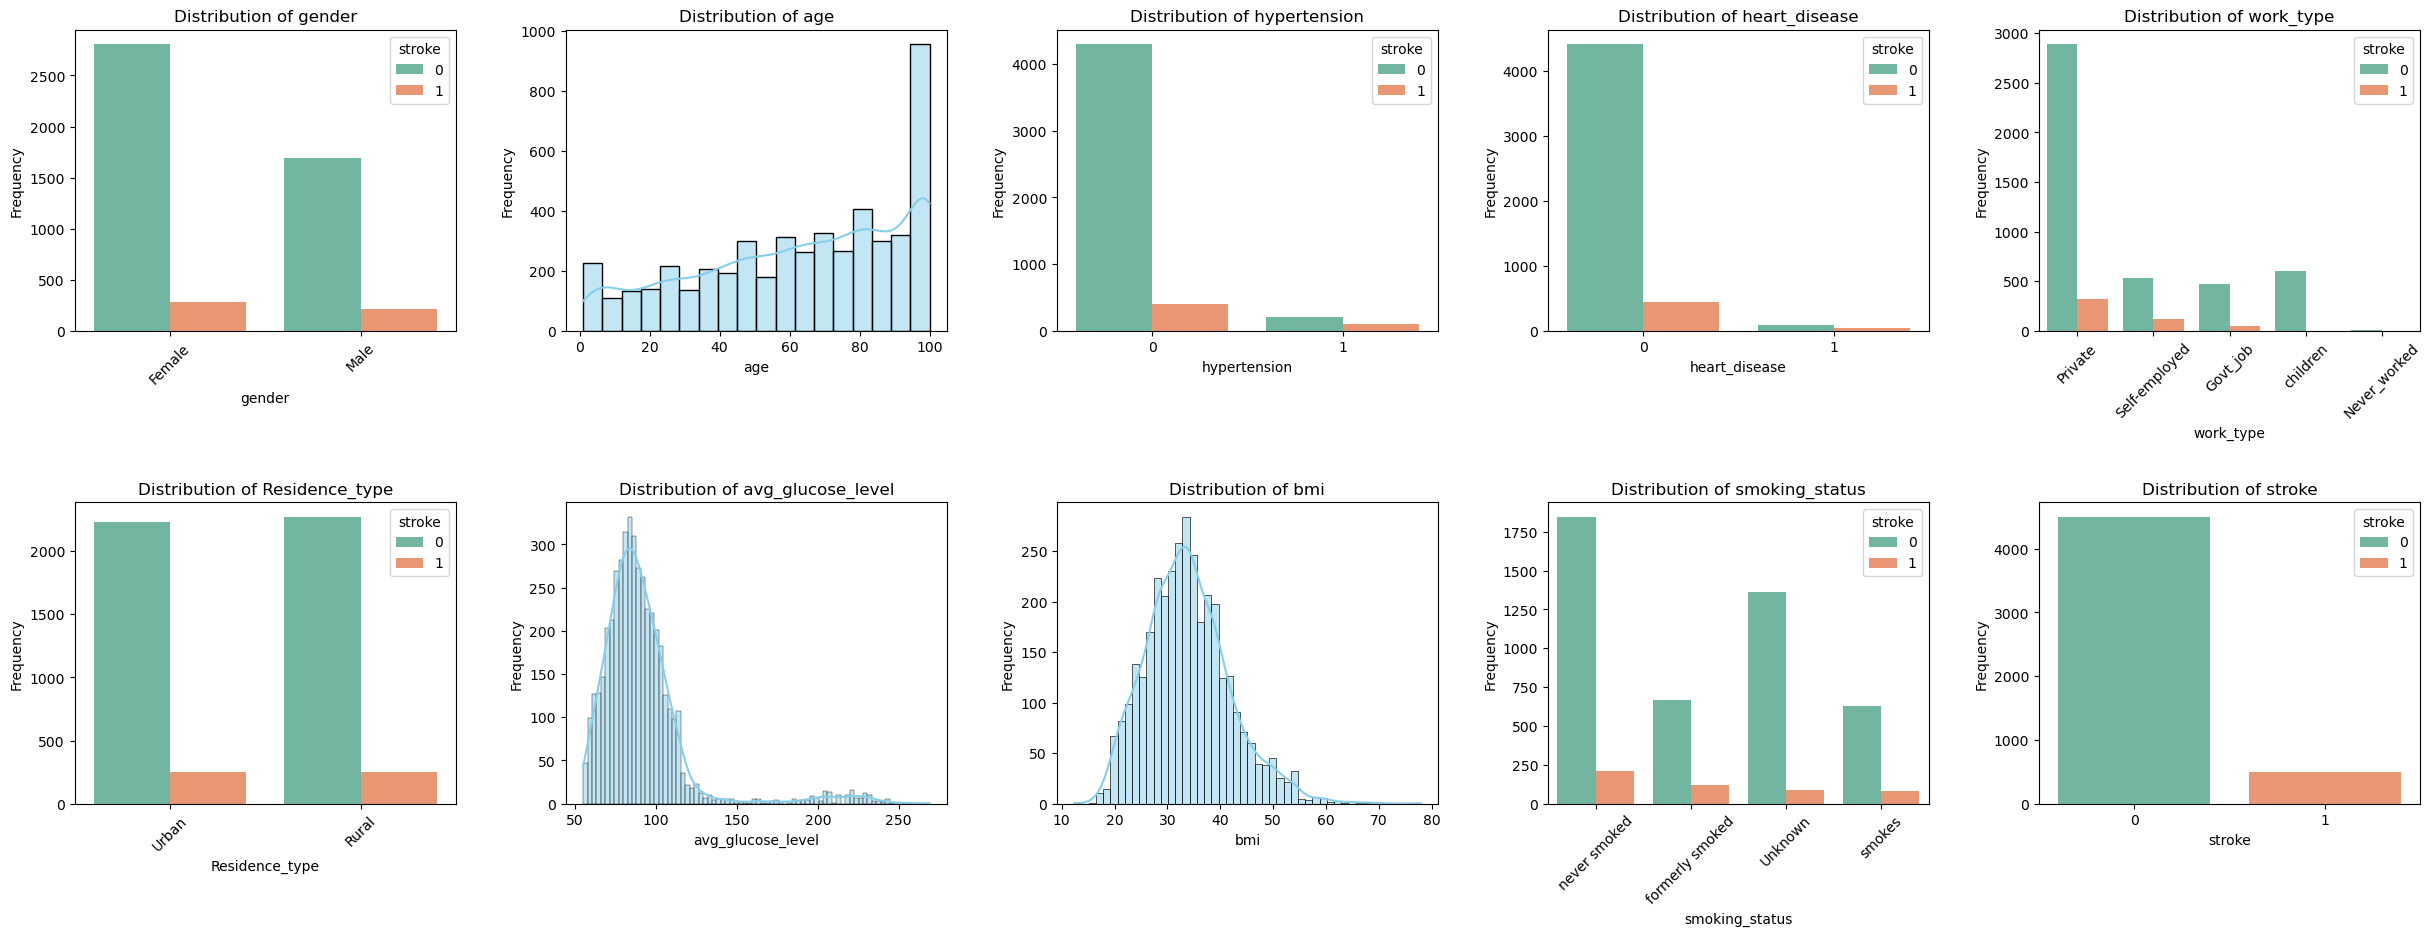

2024-06-20 11:19:10.620 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column id: 0 / 5000
2024-06-20 11:19:10.625 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column gender: 0 / 5000
2024-06-20 11:19:10.626 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column age: 0 / 5000
2024-06-20 11:19:10.626 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column hypertension: 0 / 5000
2024-06-20 11:19:10.626 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column heart_disease: 0 / 5000
2024-06-20 11:19:10.628 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column work_type: 0 / 5000
2024-06-20 11:19:10.629 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column Residence_type: 0 / 5000
2024-06-20 11:19:10.630 | INFO     | src.visualization.data

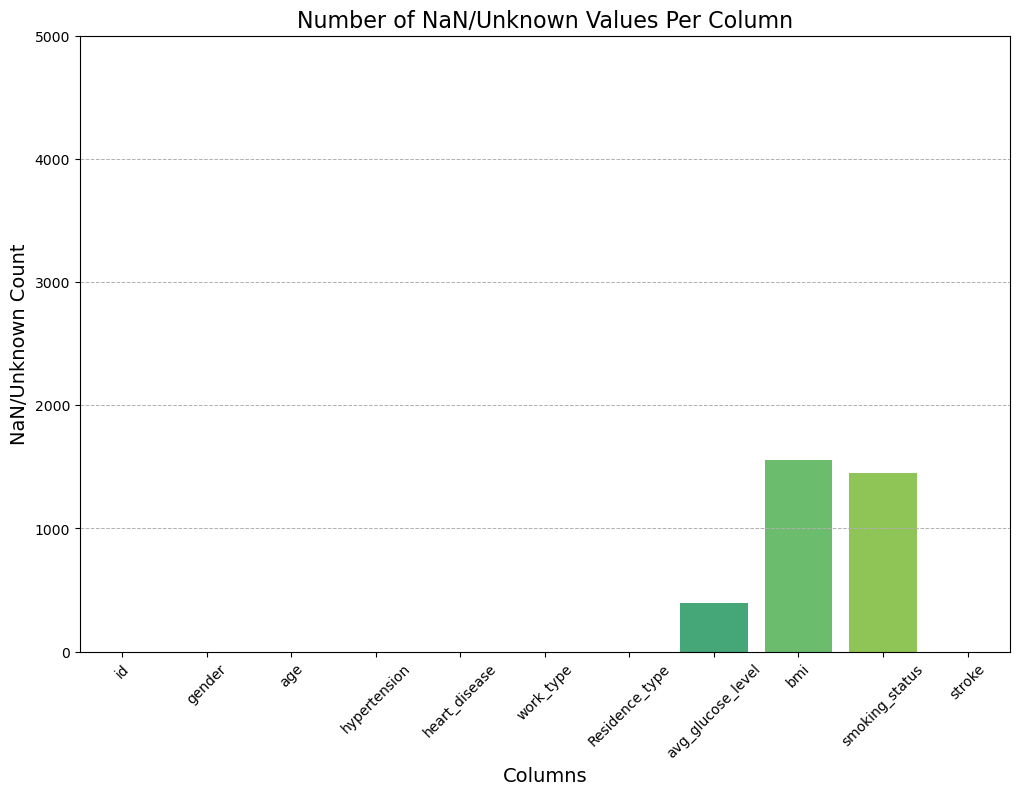

In [8]:
# visualize raw data
if visualize_data:
    data_explorer = DataExplorer()
    data_explorer.plot_distributions(data_train_raw)
    data_explorer.plot_nans(data_train_raw)
    # data_explorer.print_non_numericals(data_train_raw)

In [9]:
# preprocess data
data_preprocessor = DataPreprocessor()
data_train_preprocessed = data_preprocessor.transform_non_numericals(data_train_raw)
data_test_preprocessed = data_preprocessor.transform_non_numericals(data_test_raw)
# data_train_preprocessed = data_preprocessor.remove_nans(data_train_raw)

2024-06-20 11:19:10.785 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed gender into binary encoding
2024-06-20 11:19:10.788 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-06-20 11:19:10.789 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-06-20 11:19:10.792 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed smoking_status into one-hot encoding
2024-06-20 11:19:10.793 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed gender into binary encoding
2024-06-20 11:19:10.795 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-06-20 11:19:10.796 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-06-20 11:19:10.798 | INF

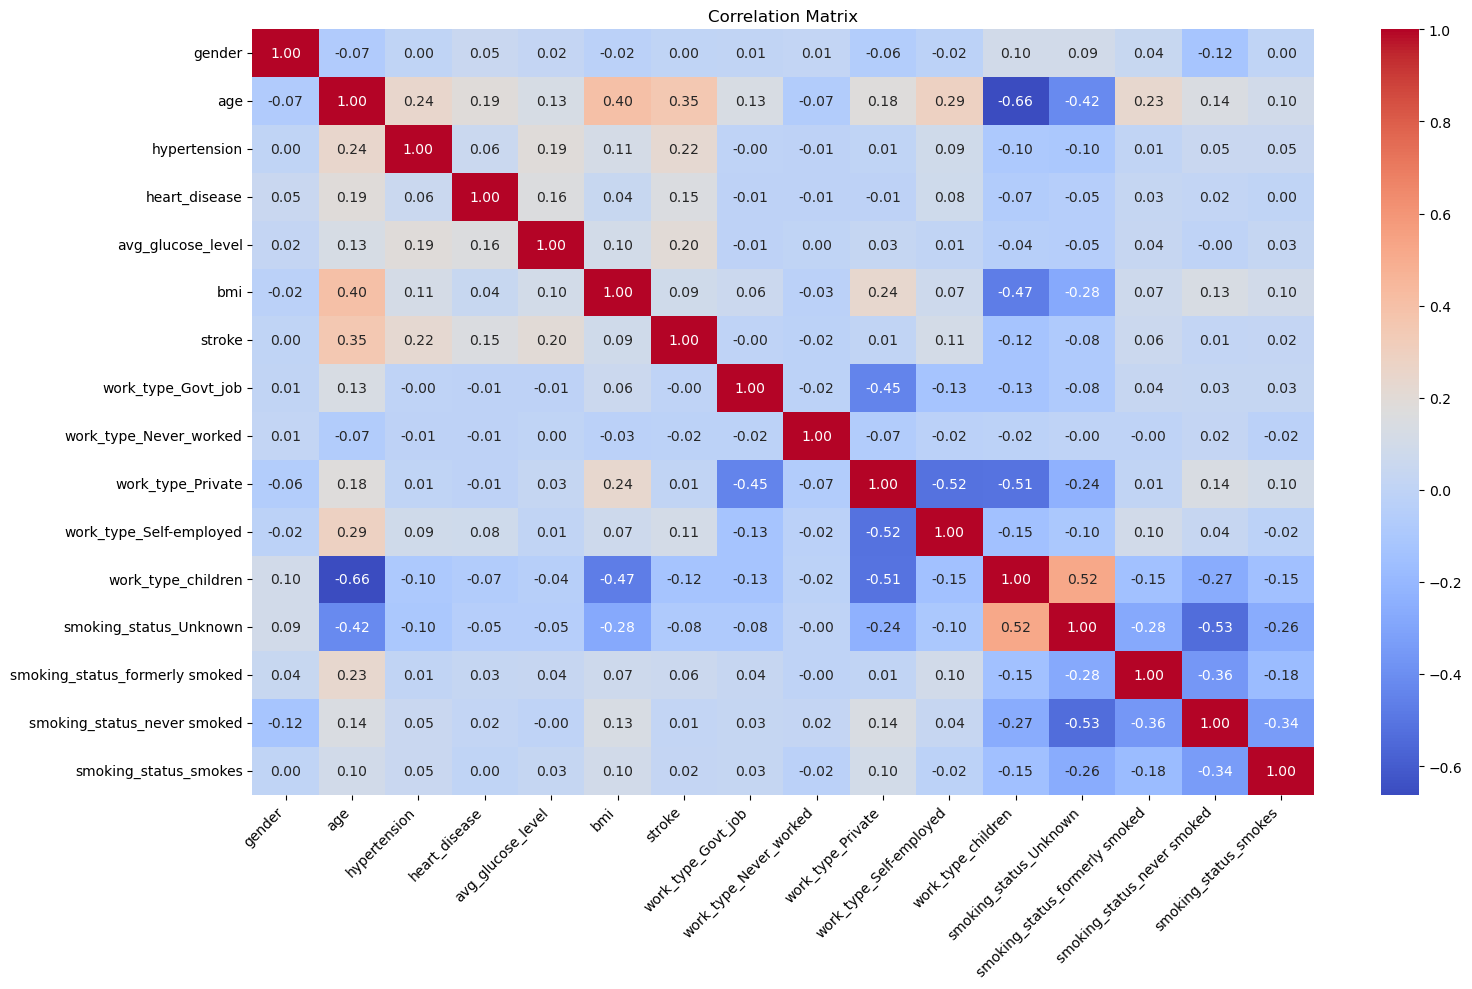

In [10]:
# feature exploration & engineering
feature_engineer = FeatureEngineer(data_train_preprocessed)
data_train_engineered = feature_engineer.drop(
    data_train_preprocessed,
    [
        "id",
        "Residence_type",
        # "work_type_Private",
        # "work_type_Govt_job",
        # "work_type_Never_worked",
        # "smoking_status_never smoked",
        # "smoking_status_smokes",
        # "smoking_status_Unknown",
        # "smoking_status_formerly smoked",
        # "gender",
    ],
)
data_train_engineered = feature_engineer.dropna(data_train_engineered)
data_train_engineered = feature_engineer.normalize_features(data_train_engineered)

# data_train_engineered = feature_engineer.combine_features(
#     data_train_engineered,
#     [["age", "bmi"], ["age", "hypertension"]],
#     "multiplicative",
# )
if visualize_data:
    data_explorer.plot_correlation_matrix(data_train_engineered)
# data_test_engineered = feature_engineer.apply_transformations(data_test_preprocessed)

In [20]:
X_train, y_train = feature_engineer.split_X_y(data_train_engineered)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

dataset_train = StrokeDataset(X_train, y_train)
dataset_val = StrokeDataset(X_val, y_val)

In [13]:
# Naive Baseline
naive_baseline = NaiveBaseline()
y_pred = naive_baseline.predict(X_val)
y_pred_proba = naive_baseline.predict_proba(X_val)
evaluate("Naive Baseline", y_val, y_pred, y_pred_proba, plot=True)

/Users/paul/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-06-20 11:20:39.939 | INFO     | src.models.evaluate:evaluate:37 - Naive Baseline – Accuracy: 0.8848580441640379, F1 score: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5
            Pred Neg  Pred Pos
Actual Neg       561         0
Actual Pos        73         0
2024-06-20 11:20:39.940 | INFO     | src.models.evaluate:evaluate:40 - number of pos preds: 0


(0.8848580441640379, 0.0, 0.5)

class_weights tensor([0.5559, 4.9706])
Epoch: 0. Train Loss: 0.6544717211276293. Val Loss: 0.6679718360304833. Val Accuracy: 80.5993690851735
Epoch: 1. Train Loss: 0.6125848583877087. Val Loss: 0.6272516757249832. Val Accuracy: 75.55205047318611
Epoch: 2. Train Loss: 0.5846920069307089. Val Loss: 0.6146258875727654. Val Accuracy: 81.38801261829653
Epoch: 3. Train Loss: 0.5674928728491068. Val Loss: 0.5888240993022918. Val Accuracy: 74.60567823343848
Epoch: 4. Train Loss: 0.5529558271169662. Val Loss: 0.5755621328949928. Val Accuracy: 73.50157728706624
Epoch: 5. Train Loss: 0.5439753361046314. Val Loss: 0.5662612929940224. Val Accuracy: 73.50157728706624
Epoch: 6. Train Loss: 0.5347588993608952. Val Loss: 0.5567828610539436. Val Accuracy: 71.29337539432177
Epoch: 7. Train Loss: 0.5283941496163607. Val Loss: 0.5521690919995308. Val Accuracy: 72.71293375394322
Epoch: 8. Train Loss: 0.5238172467797995. Val Loss: 0.5445611253380775. Val Accuracy: 66.5615141955836
Epoch: 9. Train Loss: 0.526

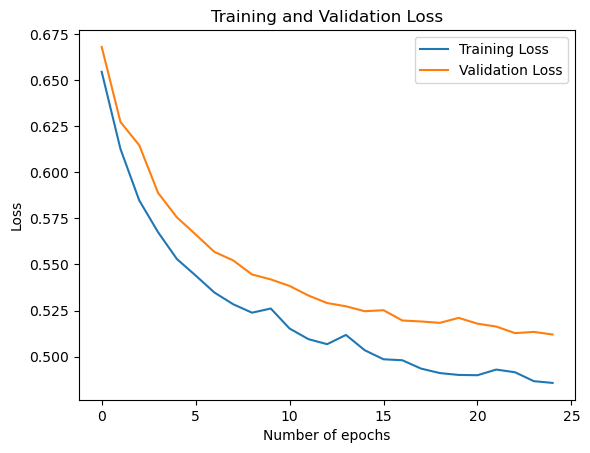

2024-06-20 11:29:58.907 | INFO     | src.models.evaluate:evaluate:37 - Logistic Regression – Accuracy: 0.7208201892744479, F1 score: 0.4158415841584158, Precision: 0.27155172413793105, Recall: 0.8873239436619719, AUC: 0.8609311285117454
            Pred Neg  Pred Pos
Actual Neg       394       169
Actual Pos         8        63
2024-06-20 11:29:58.908 | INFO     | src.models.evaluate:evaluate:40 - number of pos preds: [232]


(0.7208201892744479, 0.4158415841584158, 0.8609311285117454)

In [27]:
# Logisic Regression
log_reg = LogisticRegression(n_features=X_train.shape[1])
log_reg.fit(dataset_train, dataset_val)
y_pred = log_reg.predict(X_val)
y_pred_proba = log_reg.predict_proba(X_val)
evaluate("Logistic Regression", y_val, y_pred, y_pred_proba, plot=True)

class_weights tensor([0.5559, 4.9706])
Epoch: 0. Train Loss: 0.694806345552206. Val Loss: 0.7267212003469468. Val Accuracy: 88.801261829653
Epoch: 1. Train Loss: 0.6853885896503925. Val Loss: 0.7185495808720589. Val Accuracy: 83.91167192429022
Epoch: 2. Train Loss: 0.682855449989438. Val Loss: 0.7222298681735992. Val Accuracy: 88.801261829653
Epoch: 3. Train Loss: 0.6783160261809826. Val Loss: 0.7411951795220375. Val Accuracy: 88.801261829653
Epoch: 4. Train Loss: 0.6785958375781774. Val Loss: 0.7111057862639427. Val Accuracy: 88.64353312302839
Epoch: 5. Train Loss: 0.673718248680234. Val Loss: 0.6982546865940094. Val Accuracy: 23.028391167192428
Epoch: 6. Train Loss: 0.6654140472412109. Val Loss: 0.7087105989456177. Val Accuracy: 88.32807570977918
Epoch: 7. Train Loss: 0.6602574292570352. Val Loss: 0.69514020383358. Val Accuracy: 88.17034700315457
Epoch: 8. Train Loss: 0.6516111914068461. Val Loss: 0.675651690363884. Val Accuracy: 61.98738170347003
Epoch: 9. Train Loss: 0.649799239635

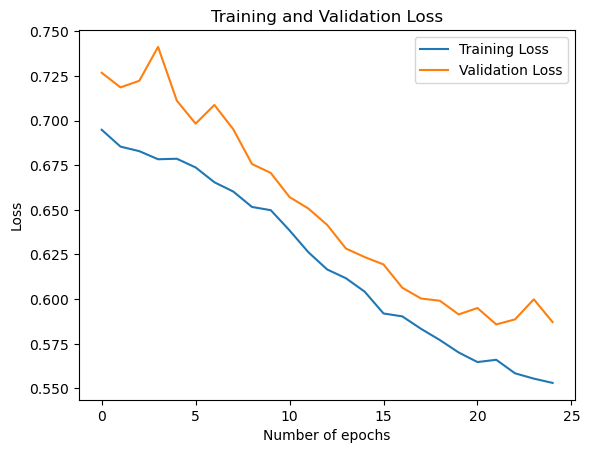

2024-06-20 11:29:43.676 | INFO     | src.models.evaluate:evaluate:37 - Neural Network – Accuracy: 0.8138801261829653, F1 score: 0.4326923076923077, Precision: 0.3284671532846715, Recall: 0.6338028169014085, AUC: 0.8521251844995372
            Pred Neg  Pred Pos
Actual Neg       471        92
Actual Pos        26        45
2024-06-20 11:29:43.677 | INFO     | src.models.evaluate:evaluate:40 - number of pos preds: [137]


(0.8138801261829653, 0.4326923076923077, 0.8521251844995372)

In [26]:
# Shallow Neural Network
neural_network = NeuralNetwork(n_features=X_train.shape[1], n_hidden=16)
neural_network.fit(dataset_train, dataset_val)
y_pred = neural_network.predict(X_val)
y_pred_proba = neural_network.predict_proba(X_val)
evaluate("Neural Network", y_val, y_pred, y_pred_proba, plot=True)